In [1]:
# Imports for the project
import random
import matplotlib.pyplot as plt
import math
from collections import Counter

# ADA511 Course Project: Yahtzee
By: Ole A. Solem & Henrik Vallestad

* We have limited our project to only the **first part of Yahtzee**, where the goal is to get as many of each kind **[1, 2, 3, 4, 5, 6]** and then sum them.
* If the **sum** of [1s, 2s, 3s, 4s, 5s, 6s] is 63, the agent gets a **bonus of 50 points**. 
* Also if the agent gets 5 of a kind, **Yahtzee**, it gets 50 points (which **do not** count on the 63-bonus, but it adds to the total score)
* We run **400 000** games for each scenario, this will give us enough data to accuratly compare them.

We have programmed four different scenarios:

1. **Greedy Algorithm**: Always keeps the highest value.
2. **Strategy with Three of a Kind**: Incorporates a strategy where we try to always get three of a kind and use probability inference to decide whether to keep multiple or discard.
3. **Probability Inference on Scenarios**: Performs probability inference on possible scenarios of [Keep or discard] for all the dice, and always uses the one that yields the highest probability.
4. **Probability Distribution and Utility Calculation**: Calculates the probability distribution for each of the dice sides, then multiplies the probabilities with its corresponding dice to get the corresponding utility. The algorithm then picks the one that yields the highest utility.


### Scenario 1: Greedy Algorithm

Now we implement our first scenario then collect some data to measure some sort of benchmark.
This code mainly consists of two parts:
- Find the most frequent number : `find_most_frequent_available_number()`
- Roll the dice we do not wish to keep : `roll_with_keep()`
- Then we have `oneRound()` which plays out one round of the game: initial roll, find frequent, reroll, frequent, reroll, frequent. The last logic returns our smallest available number in case we try to return something that isn't legal.
- Then we run an entire game, until we have filled all slots.

In [2]:
def find_most_frequent_available_number(dice, available):
    counter = Counter(dice)
    most_common = counter.most_common()
    most_common.sort(key=lambda x: (-x[1], -x[0]))
    
    for num, freq in most_common:
        if num in available:
            return num
    return 0  # Return None if no available number is found


def roll_with_keep(dice, keep):
    new_dice = [d if d == keep else random.randint(1, 6) for d in dice]
    return new_dice


def oneRound(available):
    # Initial roll
    dice = roll_with_keep([1,2,3,4,5], 0)
    keep = find_most_frequent_available_number(dice, available)
    # Second roll
    dice = roll_with_keep(dice, keep)
    keep = find_most_frequent_available_number(dice, available)
    # Last roll
    dice = roll_with_keep(dice, keep)
    keep = find_most_frequent_available_number(dice, available)

    if keep == 0:
        keep= available[0]

    return dice, keep

In [3]:
#Run time with repeat=400000 : ~ 15 sec
repeat = 400000
round_one_score = 0
game_score = 0
games_score = {}
times_yahtzee = 0
times_yahtzee_and_63 = 0

# Game Simulation
for _ in range(repeat):
    available = [1, 2, 3, 4, 5, 6]
    score = 0
    yahtzee = False
    while(len(available) > 0):
        dice, keep = oneRound(available)
        s = dice.count(keep)*keep
        if(dice.count(keep) == 5) and not yahtzee:
            yahtzee = True
            game_score += 50
            times_yahtzee += 1
        else:
            available.remove(keep)
            score += s
    round_one_score += score
    game_score += score
    
    if (yahtzee) and (score >= 63):
        times_yahtzee_and_63 += 1

    if score not in games_score:
        games_score[score] = 1
    else:
        games_score[score] += 1


AVG score after 400000 games : 56.373735
Times player got yahtzee : 69626
Times player got yahtzee and over 63 : 17825

Percentage of games :: Score over 63 : 22.0%
percentage of games :: yahtzee : 17.4%
percentage of games :: yahtzee and score over 63 : 4.5%


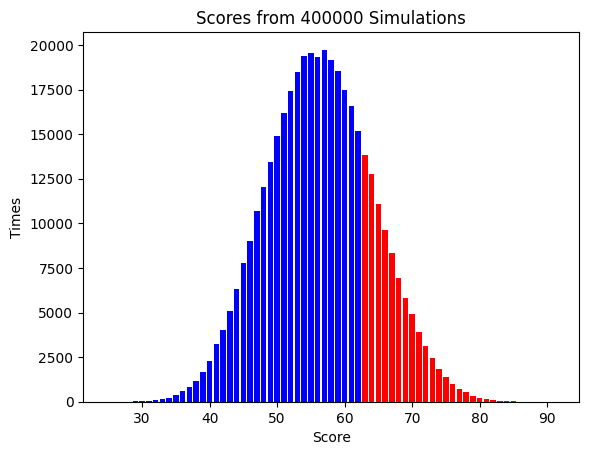

In [4]:
# Benchmark from our programmed inference and decision

print(f"AVG score after {repeat} games : {round_one_score/repeat}")
print(f"Times player got yahtzee : {times_yahtzee}")
print(f"Times player got yahtzee and over 63 : {times_yahtzee_and_63}")
print("")

Ysum = 0
for key, value in games_score.items():
    if key >= 63:
        Ysum += value

print(f"Percentage of games :: Score over 63 : {round((Ysum/repeat),2)*100}%")
print(f"percentage of games :: yahtzee : {round((times_yahtzee/repeat),3)*100}%")
print(f"percentage of games :: yahtzee and score over 63 : {round((times_yahtzee_and_63/repeat),3)*100}%")
# Plotting the scores from games_score
colors = ['red' if score >= 63 else 'blue' for score in games_score.keys()]
plt.bar(games_score.keys(), games_score.values(), color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {repeat} Simulations')
plt.show()

### Scenario 2: Strategy with Three of a Kind

The thought behind this is that in order to get the **63-bonus of 50 points**, we want to get an **average of three dice on each kind**.

* We start out with an initial inference on the dice to get the probabilities of "three of a kind" and "probability of Yahtzee". 
* In our inference we also give a huge bonus for dice that is 3 or above, since they already are 3x
* However, we penalize the number 1 because in the end it doesn't really contribute all that much to the final score.
* For example if we roll 1,1,1,6,6 : then 6,6 is higher rated

Then we do a `KeepDiceDecision()` which gives us the number of different dice we should keep. It does this by doing an inference on the different probabilities when keeping multiple dice `keepMultipleInference()`. We do this until we reach our final decision, `endTurnDecision()`, where we do a greedy inference if we didn't get a clear decision. Also, if we decided to keep 4, 5, or 6 but we didn't have three of them, we can set our 1-spot to zero instead of wasting our "good spots" on a bad score. This can only be done once.
